In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division
from __future__ import print_function

import sys, os, gc
import tensorflow as tf
import numpy as np
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc


sys.path.append('../')
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from models.neural_network import NeuralNetwork
from models.cnn import CNN
from models.util import *


#Seed used for choosing classes, training points, and test points.
#SEED = 14
SEED=11

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Define params of model
input_shape = (28,28,1)
num_classes = 10
eps=0.3

In [ ]:
%%capture one
#Load model from disk
model_name = 'MNIST'
model_save_path = '../trained_models/' + model_name + '-model.json'
weights_save_path = '../trained_models/' + model_name + 'weights'
model = CNN(model_name=model_name, dataset='mnist', seed=SEED)
print ('Total Model Params: %d' % model.num_params)
#model.load_model(model_save_path, weights_save_path) 
epochs = 30
model.train(epochs=epochs)
model.save_model(model_save_path, weights_save_path)    

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [ ]:
#Model Accuracy
print ('Model Accuracy: %.5f' % (model.model.evaluate(model.val_data, model.val_labels)[1]))

In [ ]:
%%capture two
#Get training samples
num_train_samples = 1000
data_indices = model.gen_rand_indices(low=0, high=model.train_data.shape[0], seed=SEED, num_samples=num_train_samples)
train_data = model.train_data[data_indices]
train_data_labels = model.train_labels[data_indices]
train_data_labels_int = np.argmax(train_data_labels, axis=1)

**GREYBOX ATTACKS**

In [ ]:
%%capture three
num_test_samples_per_class = 100
num_test_samples = num_classes*num_test_samples_per_class

#Generate test points
test_indices = model.gen_rand_indices_all_classes(y=model.test_labels, seed=SEED, num_samples=num_test_samples_per_class)

In [ ]:
%%capture four
#Get Regular, JSMA, DF, and CW test points
reg_data = model.test_data[test_indices]
jsma_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices], seed=SEED, perturbation='JSMA', iterations=10, eps=eps)
cwl0_data = model.generate_perturbed_data(model.test_data[test_indices], seed=SEED, perturbation='CW-l0', eps=eps)
cwl2_data = model.generate_perturbed_data(model.test_data[test_indices], seed=SEED, perturbation='CW-l2', eps=eps)
df_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='DF', nb_candidate=num_classes)

In [9]:
np.save('reg_data_mnist', reg_data)
np.save('jsma_data_mnist', jsma_data)
np.save('cwl0_data_mnist', cwl0_data)
np.save('cwl2_data_mnist', cwl2_data)
np.save('df_data_mnist', df_data)

In [12]:
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='mnist', seed=SEED)
model.load_model(model_save_path, weights_save_path)    

DOne
Loaded model from disk


In [13]:
print ('Model Accuracy REG: %.5f' % (model.model.evaluate(reg_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy CW-l0: %.5f' % (model.model.evaluate(cwl0_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy CW-l2: %.5f' % (model.model.evaluate(cwl2_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy DF: %.5f' % (model.model.evaluate(df_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy JSMA: %.5f' % (model.model.evaluate(jsma_data,model.test_labels[test_indices])[1]))

1000/1000 [==============================] - 0s 102us/step
Model Accuracy REG: 0.97700
1000/1000 [==============================] - 0s 49us/step
Model Accuracy CW-l0: 0.01700
1000/1000 [==============================] - 0s 50us/step
Model Accuracy CW-l2: 0.01700
1000/1000 [==============================] - 0s 48us/step
Model Accuracy DF: 0.01700
1000/1000 [==============================] - 0s 47us/step
Model Accuracy JSMA: 0.64100


Training Data: 


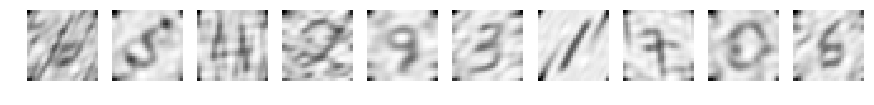

In [14]:
#Lets visualize training data
x_vis = np.random.choice(range(0,num_train_samples), 10)
print ('Training Data: ')
visualize(train_data[x_vis].reshape(-1,*input_shape), 10, '../figures/train-mnist')

Regular: 


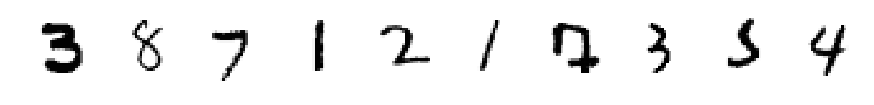

CW-l0: 


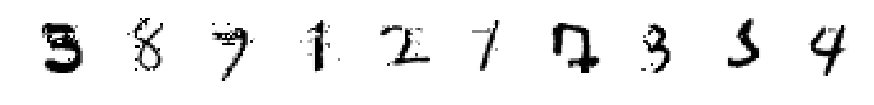

CW-l2: 


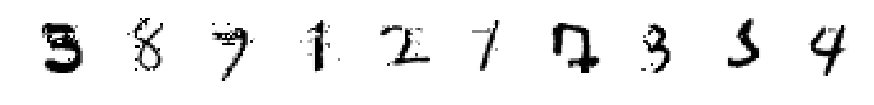

DF: 


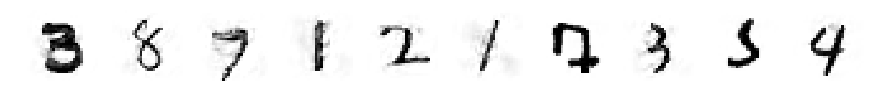

JSMA: 


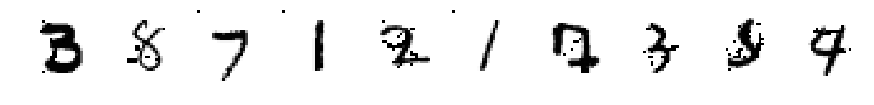

In [15]:
#Lets visualize samples from each attack
x_vis = np.random.choice(range(0,num_test_samples), 10)
print ('Regular: ')
visualize(reg_data[x_vis].reshape(-1,*input_shape), 10, '../figures/reg-mnist')
print ('CW-l0: ')
visualize(cwl0_data[x_vis].reshape(-1,*input_shape), 10, '../figures/cwl0-mnist')
print ('CW-l2: ')
visualize(cwl0_data[x_vis].reshape(-1,*input_shape), 10, '../figures/cwl2-mnist')
print ('DF: ')
visualize(df_data[x_vis].reshape(-1,*input_shape), 10, '../figures/df-mnist')
print ('JSMA: ')
visualize(jsma_data[x_vis].reshape(-1,*input_shape), 10, '../figures/jsma-mnist')

In [16]:
#Get predictions
reg_preds = model.model.predict(reg_data.reshape(-1,*input_shape))
cwl0_preds = model.model.predict(cwl0_data.reshape(-1,*input_shape))
cwl2_preds = model.model.predict(cwl2_data.reshape(-1,*input_shape))
df_preds = model.model.predict(df_data.reshape(-1,*input_shape))
jsma_preds = model.model.predict(jsma_data.reshape(-1,*input_shape))

#Convert preds to labels
reg_labels = preds_to_labels(reg_preds)
cwl0_labels = preds_to_labels(cwl0_preds)
cwl2_labels = preds_to_labels(cwl2_preds)
df_labels = preds_to_labels(df_preds)
jsma_labels = preds_to_labels(jsma_preds)

#Select Adversarial Points (i.e. points that lead to misclassification)
true_preds = np.argmax(model.test_labels[test_indices], axis=1)

#Check which points are actually adversarial and select those
cwl0_idx = np.where(np.argmax(cwl0_preds, axis=1) != true_preds)[0]
cwl2_idx = np.where(np.argmax(cwl2_preds, axis=1) != true_preds)[0]
df_idx = np.where(np.argmax(df_preds, axis=1) != true_preds)[0]
jsma_idx = np.where(np.argmax(jsma_preds, axis=1) != true_preds)[0]


#Filter data points to be used for similarity
cwl0_data_fil = cwl0_data[cwl0_idx]
cwl2_data_fil = cwl2_data[cwl2_idx]
df_data_fil = df_data[df_idx]
jsma_data_fil = jsma_data[jsma_idx]


#Filter labels to be used
cwl0_labels_fil = cwl0_labels[cwl0_idx]
cwl2_labels_fil = cwl2_labels[cwl2_idx]
df_labels_fil = df_labels[df_idx]
jsma_labels_fil = jsma_labels[jsma_idx]

In [17]:
#Get l-2 distortion 
print ('CW-l2: %.5f' % (avg_l2_dist(reg_data[cwl2_idx], cwl2_data_fil)))
print ('DF: %.5f' % (avg_l2_dist(reg_data[df_idx], df_data_fil)))

CW-l2: 1.58311
DF: 2.02305


In [18]:
#Get l-0 distortion 
print ('CW-l0: %.5f' % (avg_l0_dist(reg_data[cwl0_idx], cwl0_data_fil)))
print ('JSMA: %.5f' % (avg_l0_dist(reg_data[jsma_idx], jsma_data_fil)))

CW-l0: 17.00000
JSMA: 23.00000


In [46]:
avg=0.0
ratios = []
for i,j in enumerate(cwl2_idx):
    r = np.linalg.norm(reg_data[j]-cwl2_data_fil[i])/np.linalg.norm(reg_data[j])
    ratios.append(r)
    avg+=r
print(avg/1000, max(ratios), min(ratios))

0.16932937139348359 0.4779897 0.0005641913


In [54]:
#Reconstruct CW-l0
clean_cwl0 = np.zeros(cwl0_data.shape)
for i in range(num_test_samples):
    x_adv = cwl0_data[i,:,:,0]
    x_hat = iht(x_adv,reg_data[i,:,:,0],T=100,k=40)
    #x_hat = get_top_k(np.fft.fft2(x_adv,norm='ortho'),k=40)
    clean_cwl0[i,:,:,0]= np.fft.ifft2(x_hat,norm='ortho')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


In [55]:
#Reconstruct JSMA-l0
clean_jsma = np.zeros(jsma_data.shape)
for i in range(num_test_samples):
    x_adv = jsma_data[i,:,:,0]
    x_hat = iht(x_adv,reg_data[i,:,:,0],T=100,k=40)
    #x_hat = get_top_k(np.fft.fft2(x_adv,norm='ortho'),k=40)
    clean_jsma[i,:,:,0]= np.fft.ifft2(x_hat,norm='ortho')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


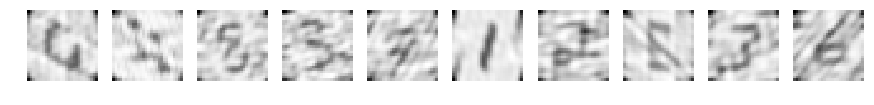

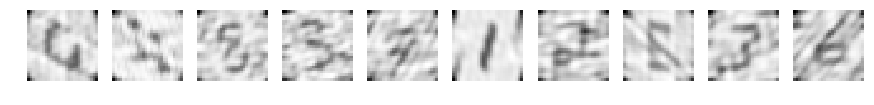

In [56]:
x_vis = np.random.choice(range(0,num_test_samples), 10)
visualize(clean[x_vis].reshape(-1,*input_shape), 10, '../figures/cwl0-clean-mnist')
visualize(clean[x_vis].reshape(-1,*input_shape), 10, '../figures/jsma-clean-mnist')

In [58]:
print ('Model Accuracy Reconstructed CW-l0: %.5f' % (model.model.evaluate(clean_cwl0,model.test_labels[test_indices])[1]))
print ('Model Accuracy Reconstructed JSMA: %.5f' % (model.model.evaluate(clean_jsma,model.test_labels[test_indices])[1]))

1000/1000 [==============================] - 0s 79us/step
Model Accuracy Reconstructed CW-l0: 0.74600
1000/1000 [==============================] - 0s 75us/step
Model Accuracy Reconstructed JSMA: 0.88500


In [64]:
np.arange(5)

array([0, 1, 2, 3, 4])

In [61]:
idft = DFT_matrix(784)

AttributeError: __exit__